Feature as described by Krzysztof Dziedzic. He also had the idea of using the WM matrix as some sort of metric so that its a weighted intersection.


----------


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import defaultdict
from nltk.corpus import stopwords


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [3]:
train_orig =  pd.read_csv('../data/train.csv', header=0)
test_orig =  pd.read_csv('../data/test.csv', header=0)

In [4]:
ques = pd.concat([train_orig[['question1', 'question2']], \
        test_orig[['question1', 'question2']]], axis=0).reset_index(drop='index')
ques.shape

(2750086, 2)

In [5]:
stops = set(stopwords.words("english"))
def word_match_share(q1, q2, stops=None):
    q1 = str(q1).lower().split()
    q2 = str(q2).lower().split()
    q1words = {}
    q2words = {}
    for word in q1:
        if word not in stops:
            q1words[word] = 1
    for word in q2:
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0.
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

In [6]:
q_dict = defaultdict(dict)
for i in range(ques.shape[0]):
        wm = word_match_share(ques.question1[i], ques.question2[i], stops=stops)
        q_dict[ques.question1[i]][ques.question2[i]] = wm
        q_dict[ques.question2[i]][ques.question1[i]] = wm

In [7]:
def q1_q2_intersect(row):
    return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))
def q1_q2_wm_ratio(row):
    q1 = q_dict[row['question1']]
    q2 = q_dict[row['question2']]
    inter_keys = set(q1.keys()).intersection(set(q2.keys()))
    if(len(inter_keys) == 0): return 0.
    inter_wm = 0.
    total_wm = 0.
    for q,wm in q1.items():
        if q in inter_keys:
            inter_wm += wm
        total_wm += wm
    for q,wm in q2.items():
        if q in inter_keys:
            inter_wm += wm
        total_wm += wm
    if(total_wm == 0.): return 0.
    return inter_wm/total_wm

In [8]:
train_orig['q1_q2_wm_ratio'] = train_orig.apply(q1_q2_wm_ratio, axis=1, raw=True)
test_orig['q1_q2_wm_ratio'] = test_orig.apply(q1_q2_wm_ratio, axis=1, raw=True)

In [9]:
train_orig['q1_q2_intersect'] = train_orig.apply(q1_q2_intersect, axis=1, raw=True)
test_orig['q1_q2_intersect'] = test_orig.apply(q1_q2_intersect, axis=1, raw=True)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

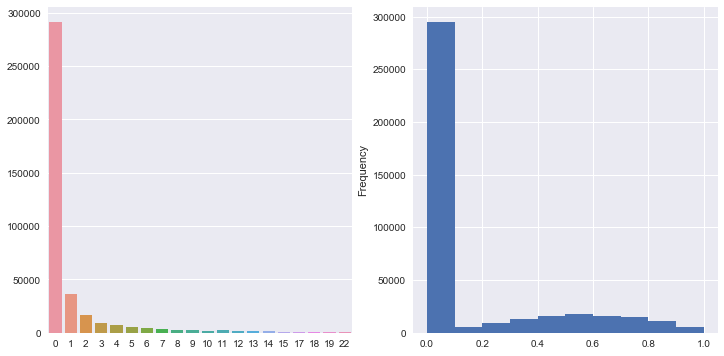

In [11]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
temp = train_orig.q1_q2_intersect.value_counts()
sns.barplot(temp.index[:20], temp.values[:20])
plt.subplot(1,2,2)
train_orig['q1_q2_wm_ratio'].plot.hist()

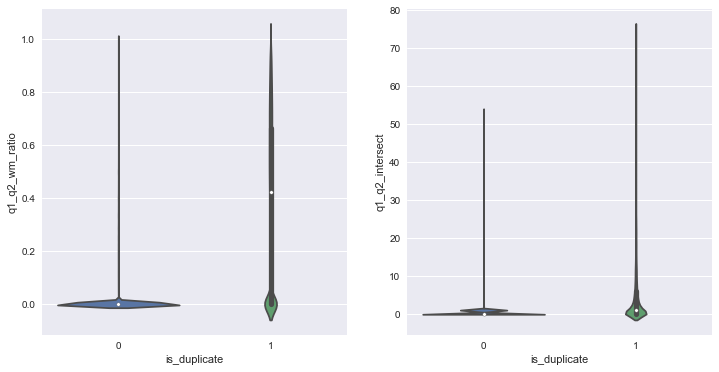

In [12]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='q1_q2_wm_ratio', data = train_orig)
plt.subplot(1,2,2)
sns.violinplot(x='is_duplicate', y='q1_q2_intersect', data = train_orig)

                 q1_q2_intersect  q1_q2_wm_ratio
q1_q2_intersect         1.000000        0.684574
q1_q2_wm_ratio          0.684574        1.000000


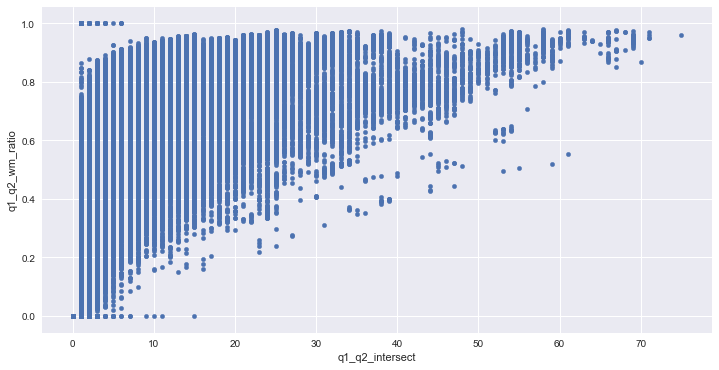

In [13]:
train_orig.plot.scatter(x='q1_q2_intersect', y='q1_q2_wm_ratio', figsize=(12,6))
print(train_orig[['q1_q2_intersect', 'q1_q2_wm_ratio']].corr())

In [18]:
train_feat = train_orig[[ 'q1_q2_wm_ratio']]
test_feat = test_orig[['q1_q2_wm_ratio']]

In [20]:
train_feat.to_csv('../train/new_magic_train.csv')
test_feat.to_csv('../test/new_magic_test.csv')